In [1]:
!python -V

Python 3.10.4


In [2]:
import os
from pathlib import Path

_data_root = os.path.join("./../", 'data')
_data_root_raw = os.path.join(_data_root, 'raw')
_train_dirpath = os.path.join(_data_root_raw, "train")
_train_filepath = os.path.join(_train_dirpath, "train.csv")
_test_dirpath = os.path.join(_data_root_raw, "test")
_test_filepath = os.path.join(_test_dirpath, "test.csv")

os.makedirs(_train_dirpath, exist_ok=True)
os.makedirs(_test_dirpath, exist_ok=True)

## Download data from kaggle, unzip it and copy it to data folder


In [3]:
!kaggle competitions download -c titanic -p {_data_root} --force
!unzip -o {_data_root}/"titanic.zip" -d {_data_root}
!cp {_data_root}/"train.csv" {_train_filepath}
!cp {_data_root}/"test.csv" {_test_filepath}

# clean up
!rm  {_data_root}/*.csv  {_data_root}/*.zip

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 1.79MB/s]
Archive:  ./../data/titanic.zip
  inflating: ./../data/gender_submission.csv  
  inflating: ./../data/test.csv      
  inflating: ./../data/train.csv     


In [1]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


import pandas as pd
import seaborn as sns
import numpy as np
from toolz import compose
import pickle
import matplotlib.pyplot as plt

from pandas.core.common import SettingWithCopyWarning
from matplotlib_inline import backend_inline

import warnings

backend_inline.set_matplotlib_formats('svg')
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
df = pd.read_csv(_train_filepath)
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
1,733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
2,382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
3,704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
4,813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


<Figure size 792x360 with 0 Axes>

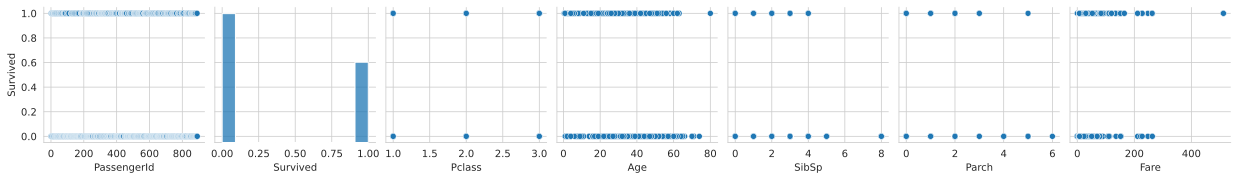

In [6]:
fig = plt.figure(figsize=(11,5))
#sns.pairplot(df)

pp = sns.pairplot(data=df,
                  #x_vars=['age'],
                  y_vars=['Survived'])

In [8]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:10])
    print(f'nunique: {df[col].nunique()}')
    print(f'isNa count: {df[col].isna().sum()}')
    print()

PassengerId
[ 1  2  3  4  5  6  7  8  9 10]
nunique: 891
isNa count: 0

Survived
[0 1]
nunique: 2
isNa count: 0

Pclass
[3 1 2]
nunique: 3
isNa count: 0

Name
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
nunique: 891
isNa count: 0

Sex
['male' 'female']
nunique: 2
isNa count: 0

Age
[22. 38. 26. 35. nan 54.  2. 27. 14.  4.]
nunique: 88
isNa count: 177

SibSp
[1 0 3 4 2 5 8]
nunique: 7
isNa count: 0

Parch
[0 1 2 5 3 4 6]
nunique: 7
isNa count: 0

Ticket
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736']
nunique: 681
isNa count: 0

Fare
[ 7.25   71.2833  7.925  53.1     8.05    8.4583 51.8625 21.075  11.1333
 30.0708]
nunique: 

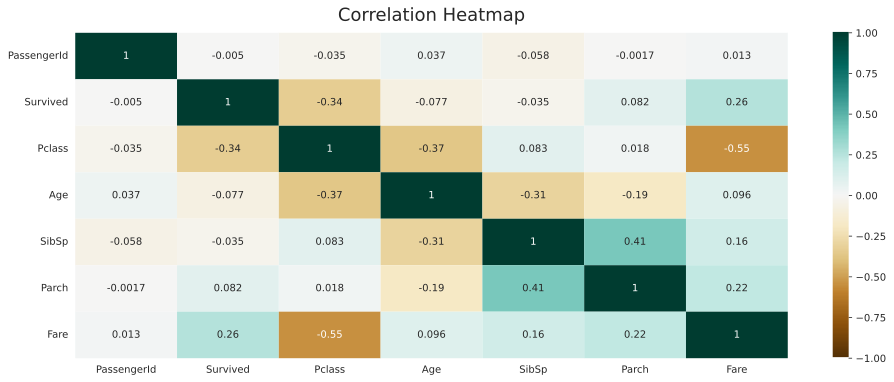

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);# save heatmap as .png file

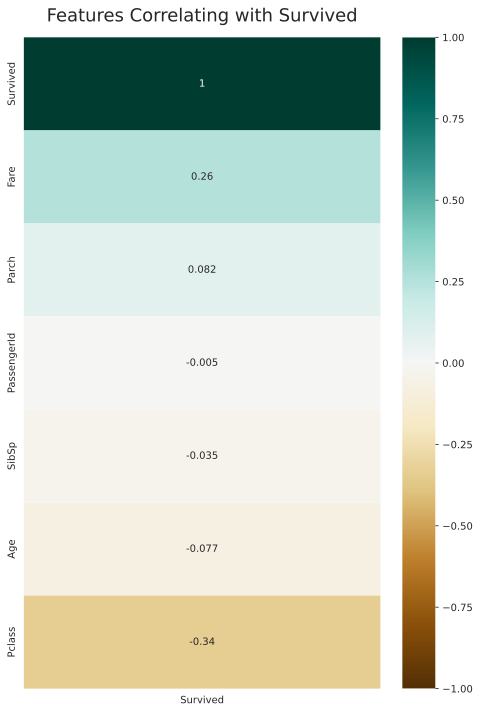

In [10]:

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Survived']].sort_values(by='Survived', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Survived', fontdict={'fontsize':18}, pad=16);



In [15]:
print(df.dtypes)
print(df.columns.to_list())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [13]:
def remove_na_data(df, columns):
    return df.dropna(subset=columns)

df_clean = remove_na_data(df, ['Embarked'])
for col in df_clean.columns:
    print(col)
    print(df_clean[col].unique()[:10])
    print(f'nunique: {df_clean[col].nunique()}')
    print(f'isNa count: {df_clean[col].isna().sum()}')
    print()

PassengerId
[ 1  2  3  4  5  6  7  8  9 10]
nunique: 889
isNa count: 0

Survived
[0 1]
nunique: 2
isNa count: 0

Pclass
[3 1 2]
nunique: 3
isNa count: 0

Name
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
nunique: 889
isNa count: 0

Sex
['male' 'female']
nunique: 2
isNa count: 0

Age
[22. 38. 26. 35. nan 54.  2. 27. 14.  4.]
nunique: 88
isNa count: 177

SibSp
[1 0 3 4 2 5 8]
nunique: 7
isNa count: 0

Parch
[0 1 2 5 3 4 6]
nunique: 7
isNa count: 0

Ticket
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736']
nunique: 680
isNa count: 0

Fare
[ 7.25   71.2833  7.925  53.1     8.05    8.4583 51.8625 21.075  11.1333
 30.0708]
nunique: 

In [15]:
from sklearn.metrics import mutual_info_score

to_drop = ['Cabin', 'Ticket']
categorical = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
numerical = ['Fare']
print('categorical: ', categorical)
print('numerical: ', numerical)


categorical:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
numerical:  ['Fare']


In [16]:


def mutual_info_Survived(series):
    return mutual_info_score(series, df_clean.Survived)

mi = df_clean[categorical].apply(mutual_info_Survived)
mi_df = pd.DataFrame(round(mi.sort_values(ascending=False), 2), columns=['MI'])
mi_df



,MI
Survived,0.67
Sex,0.15
Pclass,0.06
SibSp,0.02
Parch,0.02
Embarked,0.01


In [20]:
categorical = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
#numerical = ['Age', 'Fare']
numerical = ['Fare']

def prepare_dictionaries(df: pd.DataFrame):
    categorical = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
    numerical = ['Age', 'Fare']

    df[categorical] = df[categorical].fillna(-1).astype('str')

    dicts = df[categorical + numerical].to_dict(orient='records')

    return dicts

In [21]:
prepare_dictionaries(df_clean)

[{'Sex': 'male',
  'Pclass': '3',
  'Embarked': 'S',
  'SibSp': '1',
  'Parch': '0',
  'Age': 22.0,
  'Fare': 7.25},
 {'Sex': 'female',
  'Pclass': '1',
  'Embarked': 'C',
  'SibSp': '1',
  'Parch': '0',
  'Age': 38.0,
  'Fare': 71.2833},
 {'Sex': 'female',
  'Pclass': '3',
  'Embarked': 'S',
  'SibSp': '0',
  'Parch': '0',
  'Age': 26.0,
  'Fare': 7.925},
 {'Sex': 'female',
  'Pclass': '1',
  'Embarked': 'S',
  'SibSp': '1',
  'Parch': '0',
  'Age': 35.0,
  'Fare': 53.1},
 {'Sex': 'male',
  'Pclass': '3',
  'Embarked': 'S',
  'SibSp': '0',
  'Parch': '0',
  'Age': 35.0,
  'Fare': 8.05},
 {'Sex': 'male',
  'Pclass': '3',
  'Embarked': 'Q',
  'SibSp': '0',
  'Parch': '0',
  'Age': nan,
  'Fare': 8.4583},
 {'Sex': 'male',
  'Pclass': '1',
  'Embarked': 'S',
  'SibSp': '0',
  'Parch': '0',
  'Age': 54.0,
  'Fare': 51.8625},
 {'Sex': 'male',
  'Pclass': '3',
  'Embarked': 'S',
  'SibSp': '3',
  'Parch': '1',
  'Age': 2.0,
  'Fare': 21.075},
 {'Sex': 'female',
  'Pclass': '3',
  'Embarked':

In [22]:
def remove_na_data(df, columns):
    return df.dropna(subset=columns)

def clean_data(df: pd.DataFrame):
    return remove_na_data(df, ['Embarked'])

df_clean = remove_na_data(df, ['Embarked'])
for col in df_clean.columns:
    print(col)
    print(df_clean[col].unique()[:10])
    print(f'nunique: {df_clean[col].nunique()}')
    print(f'isNa count: {df_clean[col].isna().sum()}')
    print()




PassengerId
[ 1  2  3  4  5  6  7  8  9 10]
nunique: 889
isNa count: 0

Survived
[0 1]
nunique: 2
isNa count: 0

Pclass
[3 1 2]
nunique: 3
isNa count: 0

Name
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
nunique: 889
isNa count: 0

Sex
['male' 'female']
nunique: 2
isNa count: 0

Age
[22. 38. 26. 35. nan 54.  2. 27. 14.  4.]
nunique: 88
isNa count: 177

SibSp
[1 0 3 4 2 5 8]
nunique: 7
isNa count: 0

Parch
[0 1 2 5 3 4 6]
nunique: 7
isNa count: 0

Ticket
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736']
nunique: 680
isNa count: 0

Fare
[ 7.25   71.2833  7.925  53.1     8.05    8.4583 51.8625 21.075  11.1333
 30.0708]
nunique: 

In [32]:
def compute_targets(data):
    targets = data.Survived.values
    return targets

def preprocess_df(df: pd.DataFrame, transforms, categorical, numerical):
    """Return processed features dict and target."""

    # Apply in-between transformations
    df = compose(*transforms[::-1])(df)

    # For dict vectorizer: int = ignored, str = one-hot
    df[categorical] = df[categorical].astype(str)

    # Convert dataframe to feature dictionaries
    feature_dicts = df[categorical + numerical].to_dict(orient='records')

    return feature_dicts


def read_data(filename):
    """Return processed features dict and target."""

    # Load dataset
    if filename.endswith('parquet'):
        df = pd.read_parquet(filename)
    elif filename.endswith('csv'):
        df = pd.read_csv(filename)
    else:
        raise "Error: not supported file format."

    return df


def preprocess_and_extract_target(filename, transforms, categorical, numerical):
    df = read_data(filename)

    feature_dicts = preprocess_df(df, transforms, categorical, numerical)
    targets = compute_targets(df)

    return feature_dicts, targets

def preprocess_no_extract_target(filename, transforms, categorical, numerical):
    df = read_data(filename)

    feature_dicts = preprocess_df(df, transforms, categorical, numerical)

    return feature_dicts


In [45]:
from sklearn.model_selection import train_test_split

#df_train = df_train.reset_index(drop=True)
#df_val = df_val.reset_index(drop=True)

In [46]:

# In-between transformations
transforms = []
categorical = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']
numerical = ['Fare']

df_train_full = read_data(_train_filepath)

df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=42)

train_dicts, y_train = preprocess_df(df_train, transforms, categorical, numerical), compute_targets(df_train)
val_dicts, y_val = preprocess_df(df_val, transforms, categorical, numerical), compute_targets(df_val)

test_dicts = preprocess_no_extract_target(_test_filepath, transforms, categorical, numerical)

# Fit all possible categories
dv = DictVectorizer()
dv.fit(train_dicts)

X_train = dv.transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

print(train_dicts[:5], val_dicts[:5])



[{'Sex': 'male', 'Pclass': '1', 'Embarked': 'S', 'SibSp': '0', 'Parch': '0', 'Fare': 28.5}, {'Sex': 'male', 'Pclass': '2', 'Embarked': 'S', 'SibSp': '0', 'Parch': '0', 'Fare': 13.0}, {'Sex': 'male', 'Pclass': '3', 'Embarked': 'S', 'SibSp': '0', 'Parch': '0', 'Fare': 7.925}, {'Sex': 'male', 'Pclass': '3', 'Embarked': 'S', 'SibSp': '1', 'Parch': '0', 'Fare': 7.8542}, {'Sex': 'female', 'Pclass': '3', 'Embarked': 'S', 'SibSp': '4', 'Parch': '2', 'Fare': 31.275}] [{'Sex': 'male', 'Pclass': '3', 'Embarked': 'C', 'SibSp': '1', 'Parch': '1', 'Fare': 15.2458}, {'Sex': 'male', 'Pclass': '2', 'Embarked': 'S', 'SibSp': '0', 'Parch': '0', 'Fare': 10.5}, {'Sex': 'male', 'Pclass': '3', 'Embarked': 'S', 'SibSp': '0', 'Parch': '0', 'Fare': 7.925}, {'Sex': 'female', 'Pclass': '2', 'Embarked': 'S', 'SibSp': '0', 'Parch': '1', 'Fare': 33.0}, {'Sex': 'female', 'Pclass': '3', 'Embarked': 'C', 'SibSp': '1', 'Parch': '0', 'Fare': 11.2417}]


In [49]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_pred), 4)
print(accuracy)

0.8045
